##### ADIL SIDAN EP20B003_IIT

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from typing import NamedTuple, List

### Gaussian Bandit Environment

In [60]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)

  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

### Policy

In [61]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [62]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self) -> int:
    return np.random.choice(self.arm_ids)

In [63]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    self.num_pulls_per_arm[arm_id] += 1  
    n = self.num_pulls_per_arm[arm_id]  
    self.Q[arm_id] += (arm_reward - self.Q[arm_id]) / n  


  def select_arm(self) -> int:
    if np.random.rand() < self.epsilon:
        return np.random.choice(self.arm_ids)  
    else:
        return max(self.Q, key=self.Q.get)  


In [64]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau, arm_ids):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'

  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    self.num_pulls_per_arm[arm_id] += 1
    alpha = 1 / self.num_pulls_per_arm[arm_id] 
    self.Q[arm_id] += alpha * (arm_reward - self.Q[arm_id]) 



  def select_arm(self) -> int:
    Q_values = np.array(list(self.Q.values()))
    Q_stable = Q_values - np.max(Q_values)  

    exp_values = np.exp(Q_stable / self.tau) 
    probabilities = exp_values / np.sum(exp_values)  

   
    if np.any(np.isnan(probabilities)) or np.sum(probabilities) == 0:
        probabilities = np.ones(len(self.arm_ids)) / len(self.arm_ids)

    return np.random.choice(self.arm_ids, p=probabilities)




In [65]:
class UCB(BasePolicy):
  # your code here
    def __init__(self, arm_ids: List[int], c: float = 1.5):
        self.arm_ids = arm_ids
        self.c = c  # Exploration parameter
        self.Q = {id: 0 for id in self.arm_ids}
        self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}
        self.total_pulls = 0

    @property
    def name(self):
        return f'UCB c:{self.c}'

    def reset(self) -> None:
        self.Q = {id: 0 for id in self.arm_ids}
        self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}
        self.total_pulls = 0

    def update_arm(self, arm_id: int, arm_reward: float) -> None:
        self.num_pulls_per_arm[arm_id] += 1
        self.total_pulls += 1
        n = self.num_pulls_per_arm[arm_id]  
        self.Q[arm_id] += (arm_reward - self.Q[arm_id]) / n  

    def select_arm(self) -> int:
        for arm_id in self.arm_ids:
            if self.num_pulls_per_arm[arm_id] == 0:
                return arm_id

        ucb_values = {}
        for arm_id in self.arm_ids:
            exploration_bonus = self.c * np.sqrt(np.log(max(1, self.total_pulls)) / self.num_pulls_per_arm[arm_id])
            ucb_values[arm_id] = self.Q[arm_id] + exploration_bonus

        return max(ucb_values, key=ucb_values.get)



#### Trainer

In [67]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm()
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward


def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  policy_reward_each_run = np.zeros((num_runs, timesteps))
  for run in range(num_runs):
    policy.reset()
    policy_reward = train(env, policy, timesteps)
    policy_reward_each_run[run, :] = policy_reward

  # calculate avg policy reward from policy_reward_each_run
  avg_policy_rewards = np.mean(policy_reward_each_run, axis=0) # your code here (type: nd.array, shape: (timesteps,))
  total_policy_regret = np.sum(expected_max_reward - avg_policy_rewards)
  # your code here (type: float)

  return avg_policy_rewards, total_policy_regret

In [68]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)

  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')

  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()

### Experiments

In [69]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

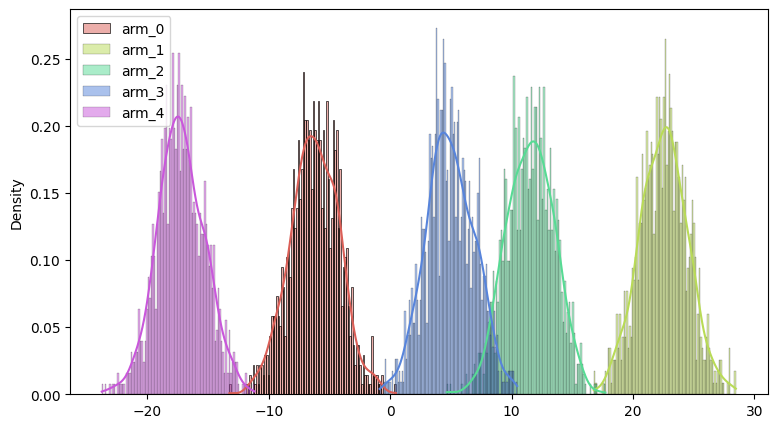

In [70]:
env = Env(num_arms, mean_reward_range, std)

env.plot_arms_reward_distribution()

In [71]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [72]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


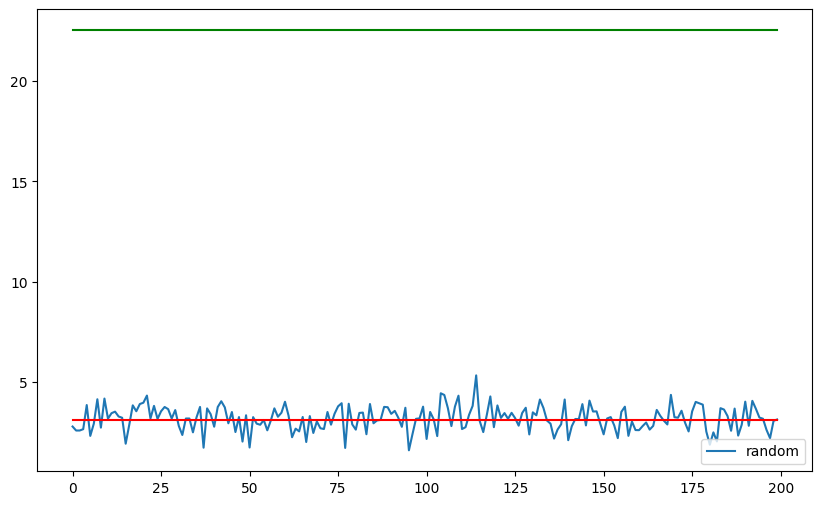

In [73]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 39.590
regret for ep-greedy ep:0.01: 83.511
regret for ep-greedy ep:0.5: 1980.353
regret for ep-greedy ep:0.9: 3505.350


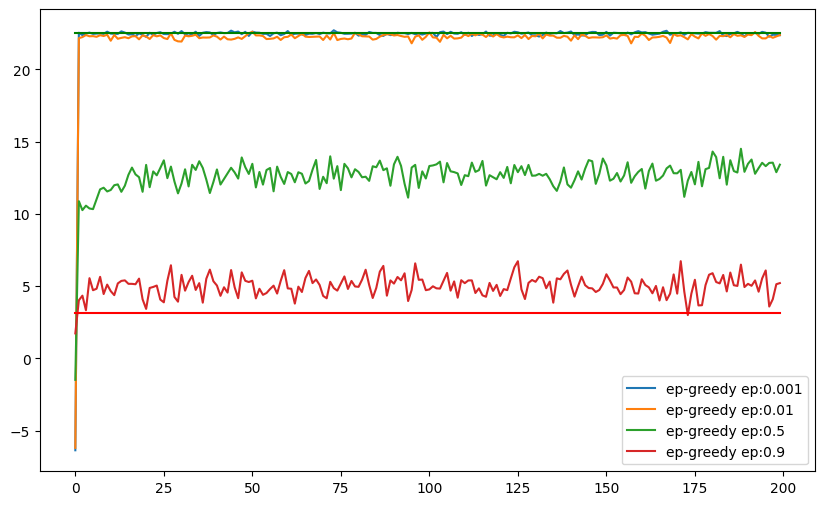

In [74]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 1922.557
regret for softmax tau:1.0: 1344.711
regret for softmax tau:5.0: 411.401
regret for softmax tau:50.0: 3150.510


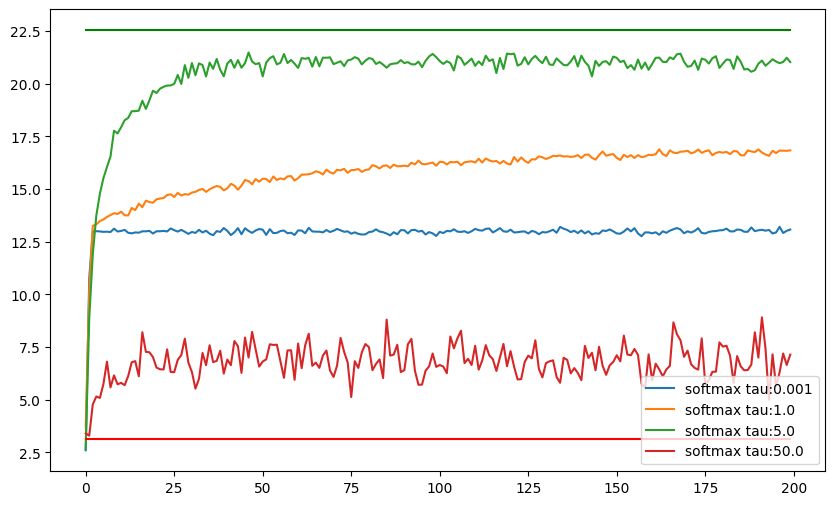

In [75]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

regret for UCB c:0.1: 95.406
regret for UCB c:0.5: 97.564
regret for UCB c:1.0: 97.449
regret for UCB c:1.5: 96.848
regret for UCB c:2.0: 97.348


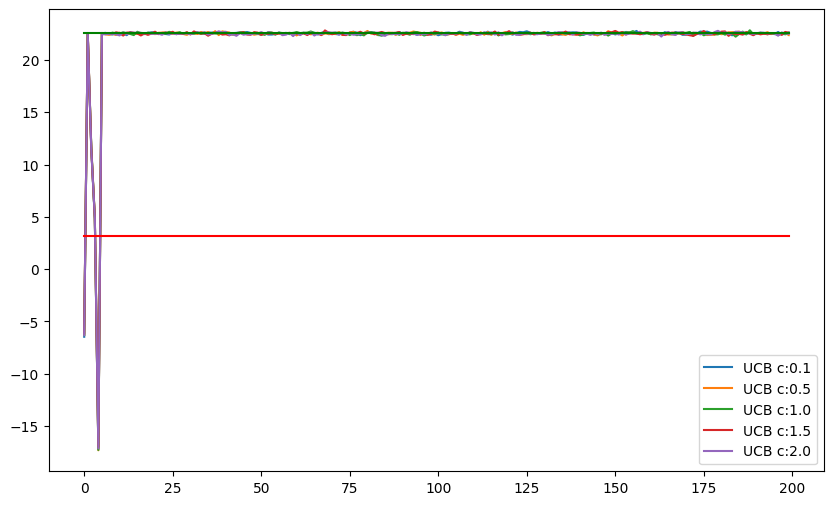

In [76]:
c_values = [0.1, 0.5, 1.0, 1.5, 2.0]
ucb_policies = [UCB(env.arm_ids, c) for c in c_values]
plot_reward_curve_and_print_regret(env, ucb_policies, timesteps=200, num_runs=500)


#### Optional: Please explore different values of epsilon, tau and verify how does the behaviour changes.

## Generate PDF

In [ ]:
!pip install nbconvert

!jupyter nbconvert --to pdf /content/your_notebook_name.ipynb
# Replace 'your_notebook_name.ipynb' with the actual name of your notebook file.
